In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [5]:
class ImageConv(nn.Sequential):
    def __init__(self):
        super().__init__(                                                                       # B 1   28  28
            nn.BatchNorm2d(num_features=1),
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=3),      # B 64  32  32  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),     # B 64  32  32
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                   # B 64  16  16
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),    # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),   # B 128 16  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                   # B 128 8   8
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),   # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),   # B 256 8   8
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                   # B 256 4   4
            nn.Dropout2d(0.2, inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),   # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),   # B 512 4   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                   # B 512 2   2
            nn.Dropout2d(0.2, inplace=True)
        )

In [37]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = ImageConv()

        self.decider = nn.Sequential(            # B 2048
            nn.Linear(2048, 512),
            nn.Dropout(0.5, inplace=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=-1)
        )
    
    def forward(self, b_x):
        # b_x   B   28  28
        b_x = b_x.unsqueeze(1)                  # B 1   28  28
        out = self.conv(b_x)                    # B 512 2   2
        out = out.flatten(1)                    # B 2048
        out = self.decider(out)                 # B 10
        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self, conv:nn.Module):
        super().__init__()

        self.conv = conv

        self.fc = nn.Sequential(
            nn.Linear(2048, 512),                                                                   # B 512
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(512, 256),                                                                    # B 256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=True),
            nn.Linear(256, 1),                                                                      # B 1
            nn.Sigmoid()
        )
    
    def forward(self, left, right):
        # left      B   28  14
        # right     B   28  14

        out = torch.cat((left, right), dim=2)   # B 28  28
        out = out.unsqueeze(1)                  # B 1   28  28
        
        with torch.no_grad():
            out = self.conv(out)                # B 512 2   2
        
        out = out.flatten(1)                    # B 2048
        out = self.fc(out)                      # B 1
        out = out.squeeze()                     # B
        return out


In [8]:
class Generator(nn.Module):
    def __init__(self, conv:nn.Module):
        super().__init__()

        self.conv = conv

        self.noise_fc = nn.Sequential(                                                              # B 100
            nn.Linear(100, 1024),                                                                   # B 1024
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.dc = nn.Sequential(                                                                                        # B 1024    2   1
            nn.BatchNorm2d(num_features=1024),
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),     # B 512     4   2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),                           # B 512     4   2
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(num_features=512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),      # B 256     8   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),                           # B 256     8   4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),      # B 128     16  8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),                           # B 128     16  8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),       # B 64      32  16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),                             # B 64      30  14
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=(0, 1)),                         # B 1       28  14
            nn.ReLU(inplace=True),
        )

    def forward(self, z, left):
        # z     B   100
        # left  B   28  14

        left = left.unsqueeze(1)                                                            # B 1   28  14

        with torch.no_grad():
            condition_features = self.conv(left)                                            # B 512 2   1
        condition_features = condition_features.flatten(1).unsqueeze(2)                     # B 1024    1

        noise_features = self.noise_fc(z).unsqueeze(2)                                      # B 1024    1

        dc_input = torch.cat((condition_features, noise_features), dim=2).unsqueeze(3)      # B 1024    2   1
        constructed = self.dc(dc_input)                                                     # B 1   28  14
        constructed = constructed.squeeze(1)                                                # B 28  14

        return constructed

In [62]:
def get_batches(X, y, batch_size, shuffle=True):
    assert X.shape[0] == y.shape[0]

    num_batches = int(np.ceil(X.shape[0] * 1.0 / batch_size))

    if shuffle:
        indices = np.random.permutation(X.shape[0])
        X = X[indices]
        y = y[indices]

    for batch in range(num_batches):
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X.shape[0])
        yield batch, X[start:end], y[start:end]

In [46]:
def train_classifier(model, optimizer, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0
    iter = 0

    model.train()
    for iter, b_X, b_y in get_batches(X, y, batch_size):
        prediction = model(torch.tensor(b_X, device='cuda').cuda())

        loss = -1 * torch.mean(prediction[torch.arange(b_X.shape[0]), b_y])
        decision = prediction.argmax(dim=1)

        epoch_loss += float(loss)
        epoch_accuracy += (decision.cpu().numpy() == b_y).sum()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    epoch_loss /= (iter + 1)
    epoch_accuracy *= 100.0 / X.shape[0]

    return epoch_loss, epoch_accuracy

In [63]:
def evaluate_classifier(model, X, y, batch_size):
    epoch_loss = 0
    epoch_accuracy = 0
    iter = 0

    with torch.no_grad():
        model.eval()
        for iter, b_X, b_y in get_batches(X, y, batch_size, shuffle=False):
            prediction = model(torch.tensor(b_X).cuda())

            loss = -1 * torch.mean(prediction[torch.arange(b_X.shape[0]), b_y])
            decision = prediction.argmax(dim=1)

            epoch_loss += float(loss)
            epoch_accuracy += (decision.cpu().numpy() == b_y).sum()
        
    epoch_loss /= (iter + 1)
    epoch_accuracy *= 100.0 / X.shape[0]

    return epoch_loss, epoch_accuracy

In [2]:
X, y = fetch_openml(name='mnist_784', return_X_y=True)

In [42]:
y = y.astype('int32')

In [43]:
X = X.reshape((X.shape[0], 28, 28)).astype('float32')
X.shape

(70000, 28, 28)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((50400, 28, 28), (14000, 28, 28), (5600, 28, 28)),
 ((50400,), (14000,), (5600,)))

## Pretrain Convolutional layer with a classifier

In [64]:
classifier = MNISTClassifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

In [65]:
batch_size = 256
epochs = 40

train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_acc = 0

for e in range(epochs):

    start_time = time()

    epoch_train_loss, epoch_train_accuracy = train_classifier(classifier, optimizer, X_train, y_train, batch_size)
    epoch_val_loss, epoch_val_accuracy = evaluate_classifier(classifier, X_val, y_val, batch_size)

    end_time = time()

    if epoch_val_accuracy > best_val_acc:
        best_val_acc = epoch_val_accuracy
        torch.save(classifier.conv.state_dict(), 'mnist-conv-model.pt')
    
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s - Train loss: {epoch_train_loss:.2e} - Train accuracy: {epoch_train_accuracy:.2f} - Val loss: {epoch_val_loss:.2e} - Val accuracy: {epoch_val_accuracy:.2f}')

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)   

Epoch   1 finished in 20.94s - Train loss: 4.18e-01 - Train accuracy: 86.70 - Val loss: 5.59e-02 - Val accuracy: 98.25
Epoch   2 finished in 21.49s - Train loss: 5.56e-02 - Train accuracy: 98.34 - Val loss: 3.59e-02 - Val accuracy: 98.84
Epoch   3 finished in 20.57s - Train loss: 3.87e-02 - Train accuracy: 98.84 - Val loss: 2.89e-02 - Val accuracy: 99.09
Epoch   4 finished in 20.31s - Train loss: 3.00e-02 - Train accuracy: 99.07 - Val loss: 2.49e-02 - Val accuracy: 99.21
Epoch   5 finished in 20.58s - Train loss: 2.39e-02 - Train accuracy: 99.26 - Val loss: 2.72e-02 - Val accuracy: 99.20
Epoch   6 finished in 20.83s - Train loss: 1.95e-02 - Train accuracy: 99.37 - Val loss: 2.60e-02 - Val accuracy: 99.20
Epoch   7 finished in 20.63s - Train loss: 1.62e-02 - Train accuracy: 99.51 - Val loss: 2.53e-02 - Val accuracy: 99.36
Epoch   8 finished in 20.55s - Train loss: 1.48e-02 - Train accuracy: 99.54 - Val loss: 2.59e-02 - Val accuracy: 99.38
Epoch   9 finished in 20.54s - Train loss: 1.29e

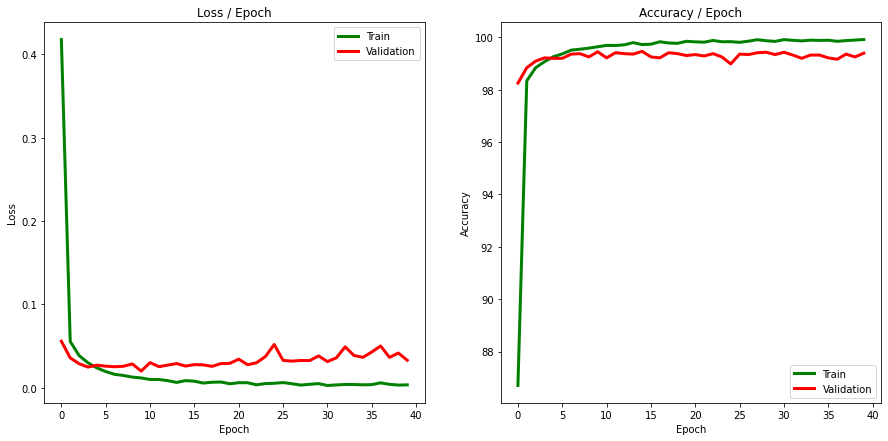

In [66]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_accuracy, label='Train', color='green', linewidth=3)
plt.plot(val_accuracy, label='Validation', color='red', linewidth=3)


plt.legend()

In [67]:
test_loss, test_accuracy = evaluate_classifier(classifier, X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.0343 - Accuracy: 99.42
